# Nonstationary Gamma distribution

If we parametrise the Gamma distribution using shape $\alpha$ and rate $\beta$ then the mean is $\alpha/\beta$ and the variance is $\alpha/\beta^2$; the mode is $(\alpha-1)/\beta$.  
Suppose that we take the location and scale parameters to refer to the mean and SD.

In [93]:
ns_loglik <- function(pars, cov, x, dist, fittype) {

  nspars <- get.ns_pars(fittype = fittype, pars = pars, fixed_cov = cov)

  loc <- nspars$loc
  scale <- nspars$scale
  shape <- nspars$shape

  # constrain variance to be strictly positive
  if(any(scale <= 0)) return(NA)

  # return negative log-likelihood
  if(dist == "norm") {
    return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
  } else if(dist == "gamma") {
      m <- loc
      v <- scale^2
      b <- m/v
      a <- b*m
      return(-sum(dgamma(x, shape = a, rate = b, log = T)))
  } else if(dist == "gev") {
    shape = pars["shape"]
    return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
  } else {
    print(paste(dist, "not implemented"))
    return()
  }
}
    
######################################################
fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm = NA, lower = F, ev_year = NA, ev = NA, method = "BFGS") {

  # if no covariate name provided, add a dummy covariate & fit stationary series instead
  if(is.na(covnm[1])) {
    data <- cbind(data, "const" = 1)
    covnm <- "const"
  }

  # remove extraneous columns from dataframes
  cov <- data[, covnm, drop = F]
  k <- length(covnm)
  x <- data[,varnm]

  # should also add something to handle case with no covariates

  # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
  if(! dist %in% c("norm", "gev", "gamma")) {
    print("Not yet implemented: use norm or gev")
    return()
  }

  # if looking at lower tail with a GEV, necessary to negate data and consider block maxima - add flag to keep track
  minima <- F
  if (lower & (dist %in% c("gev"))) {
      x <- -x
      minima <- T
  }

  # fit model with appropriate number of parameters, pad if necessary
  init <- c("mu0" = mean(x), "sigma0" = sd(x), setNames(rep(0,k), paste0("alpha_", covnm)))

  if(type %in% c("shiftscale")) init <- c(init, setNames(rep(1,k), paste0("beta_", covnm)))

  if(dist %in% c("gev")) init <- c(init, "shape" = 0)
  fitted <- suppressWarnings(optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, method = method))

  # if looking at lower tail with a GEV, necessary to flip data and consider block maxima, so trend & location parameters have been flipped. This may cause some confusion so may have to modify later!
  if(minima) {
    fitted[["NOTE"]] <- "NB: model parameters are estimated for negated values"
    fitted$par["mu0"] <- -fitted$par["mu0"]
    fitted$par[grepl("alpha", names(fitted$par))] <- -fitted$par[grepl("alpha", names(fitted$par))]
    x <- -x
  }

  # attach assorted useful information
  fitted[["dist"]] <- dist
  fitted[["type"]] <- type
  fitted[["varnm"]] <- varnm
  fitted[["covnm"]] <- covnm
  fitted[["data"]] <- data
  fitted[["x"]] <- x
  fitted[["cov"]] <- cov

  fitted[["lower"]] <- lower               # saves having to specify every time later on
  fitted[["minima"]] <- minima             # look at maxima of 0-temps, rather than minima of observed temps

  # event year: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
  if(is.na(ev_year)) { ev_year <- data$year[length(x)] }
  fitted[["ev_year"]] <- ev_year
  fitted[["ev_idx"]] <- which(data$year == ev_year)

  # event value: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
  if(is.na(ev)) {
    if(ev_year %in% data$year) {
        ev <- data[data$year == ev_year,varnm]
      } else {
        print("WARNING: Event year not in data, no event value recorded")
        ev <- -999
      }
    }
  fitted[["ev"]] <- ev

  return(fitted)
}
    
######################################################
map_to_u <- function(mdl, x, fixed_cov = NA) {

  pars <- ns_pars(mdl, fixed_cov = fixed_cov)
  if(missing(x)) x <- mdl$x

  # retrieve the actual fitted model parameters if they were negated for fitting (ie if looking at lower tails of GEV)
  if(mdl$minima) {
    pars$loc <- -pars$loc
    x = -x
    mdl$lower <- !mdl$lower # also have to look at the opposite tail
  }

  # get exceedance probability
  if(mdl$dist == "norm") {
    pit <- pnorm(x, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
      
  } else if(mdl$dist == "gamma") {
    b <- pars$loc / pars$scale^2
    a <- b*pars$loc
    pit <- pgamma(x, shape = a, rate = b, lower.tail = mdl$lower)
      
  } else if(mdl$dist == "gev") {
    pit <- sapply(1:length(pars$loc), function(i) pevd(x[i], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower))
                  
  } else {
    return(NULL)
  }
  return(pit)
}
       
                  
######################################################
map_from_u <- function(mdl, u, fixed_cov = NA) {

  if(missing(u)) u <- map_to_u(mdl, fixed_cov = fixed_cov)
  pars <- ns_pars(mdl, fixed_cov = fixed_cov)

  # retrieve the actual fitted model parameters if they were flipped for fitting
  if(mdl$minima) {
    pars$loc <- -pars$loc
    mdl$lower <- !mdl$lower       # also have to look at the opposite tail
  }

  # map quantile onto stationary distribution
  if(mdl$dist == "norm") {
    # erl <- sapply(1:length(u), function(j) {
    #     qnorm(u[j], mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
    # })
    erl <- qnorm(u, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
  } else if(mdl$dist == "gev") {
    erl <- sapply(1:length(u), function(j) {
      sapply(1:length(pars$loc), function(i) {
        qevd(u[j], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower)
      })
    })
  } else if(mdl$dist == "gamma") {
    b <- pars$loc / pars$scale^2
    a <- b*pars$loc
    erl <- qgamma(u, shape = a, rate = b, lower.tail = mdl$lower)
      
  } else {
    return(NULL)
  }

  # if parameters flipped for fitting, flip 'em back
  if(mdl$minima) erl <- -erl

  return(erl)
}

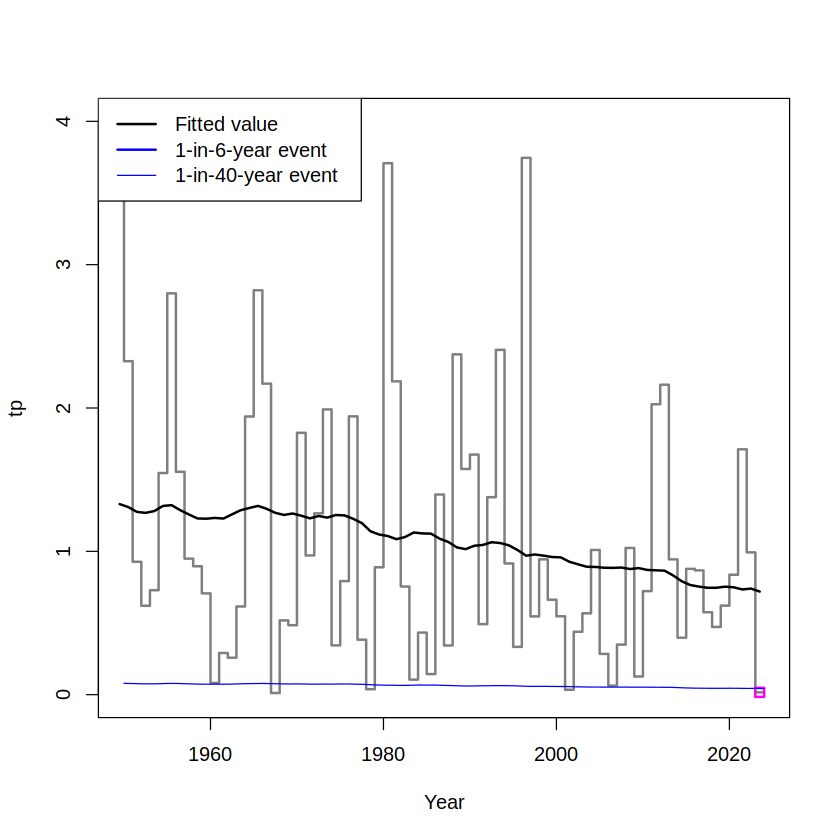

In [102]:
mdl <- fit_ns("gamma", "fixeddisp", df, "tp", "gmst", lower = T)
plot_trend(mdl)

lines(df$year, map_from_u(mdl, 1/30), col = "blue")

In [106]:
1/map_to_u(mdl)

[1]   1.066436   1.189380   2.046554   2.894683   2.520427   1.458818
 [7]   1.120752   1.434899   1.986190   2.043212   2.494965  26.360655
[13]   6.059437   7.102320   2.955779   1.283763   1.116958   1.218488
[19] 297.591406   3.401137   3.662446   1.294700   1.917726   1.599943
[25]   1.238560   5.173249   2.294718   1.248294   4.393425  60.618892
[31]   1.906922   1.026068   1.138018   2.146354  17.610386   3.645666
[37]  12.110035   1.386381   4.369547   1.094088   1.259772   1.238145
[43]   2.997956   1.379300   1.098724   1.769669   4.258696   1.014008
[49]   2.563415   1.645820   2.136617   2.512108  53.051086   2.930528
[55]   2.287145   1.491147   4.382163  24.285285   3.565000   1.463858
[61]  10.643810   1.845985   1.091306   1.074193   1.489344   2.821118
[67]   1.478705   1.477117   1.952568   2.294095   1.855016   1.504215
[73]   1.091744   1.353361  98.869580

In [92]:
qgamma(u, shape = a, rate = b, lower.tail = T)

[1] 2.870109966 2.004354912 0.854928140 0.587438873 0.680877025 1.357845133
 [7] 2.369931289 1.384447382 0.879946763 0.841914839 0.672177302 0.088644592
[13] 0.290560893 0.259528515 0.580564915 1.693400570 2.394646338 1.889244841
[19] 0.015190460 0.498058315 0.466896691 1.647531233 0.909158180 1.161237408
[25] 1.801887007 0.339378905 0.743639381 1.768570307 0.378469745 0.040296520
[31] 0.876057845 3.634499696 2.184976339 0.750752490 0.107886440 0.430739213
[37] 0.146098948 1.393846518 0.345172729 2.486930521 1.654075845 1.730484194
[43] 0.498861665 1.396876053 2.456459281 0.936947910 0.337670576 4.175781012
[49] 0.568025805 1.008590449 0.700584248 0.573711610 0.029055901 0.462247660
[55] 0.614659319 1.142932380 0.289977684 0.053901777 0.363175709 1.173239619
[61] 0.118007591 0.808522363 2.452121888 2.634448198 1.114248883 0.433010929
[67] 1.090202139 1.085862958 0.681644644 0.541793157 0.741125184 1.047112342
[73] 2.386328392 1.284053022 0.007793914

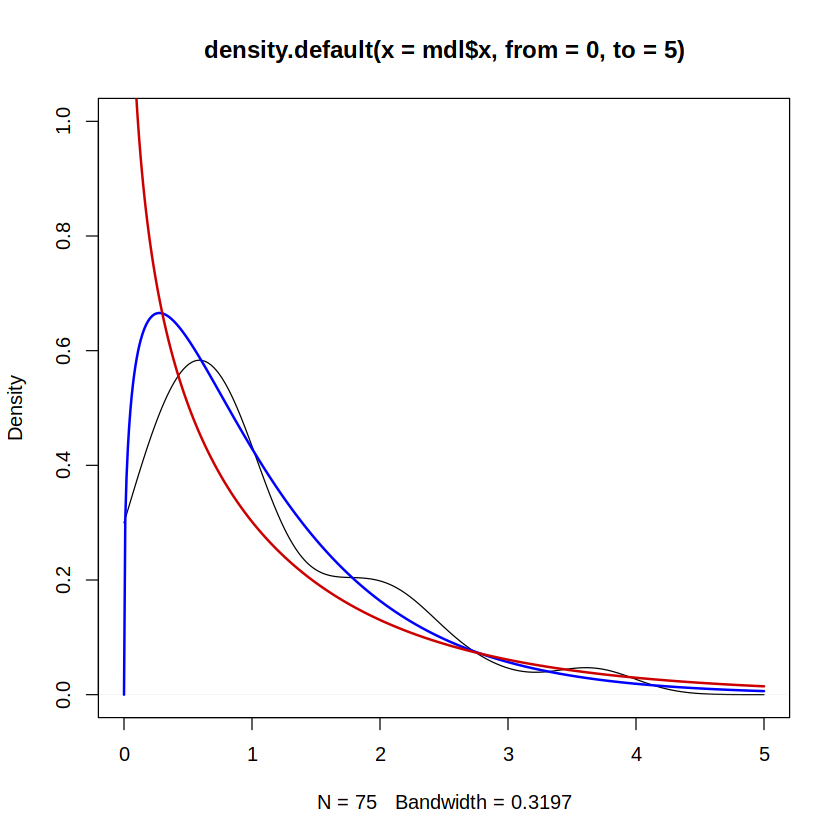

In [75]:
x <- seq(0,5,0.01)

plot(density(mdl$x, from = 0, to = 5), ylim = c(0,1))

lines(x, dgamma(x, shape = pars$loc[1], rate = pars$scale[1]), col = "blue", lwd = 2)
lines(x, dgamma(x, shape = pars$loc[75], rate = pars$scale[75]), col = "red3", lwd = 2)

In [21]:
x <- rgamma(100, 1.2, 1.12)
x <- df$tp[df$year >= 1970]

In [15]:
m <- mean(x)
v <- var(x)

In [16]:
b = m/v
a = b*m

In [17]:
a; b

[1] 1.282265

[1] 1.291646

In [18]:
fitted.gamma <- fitdistr(x, "gamma")

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1 x value <= 0 omitted from logarithmic plot”


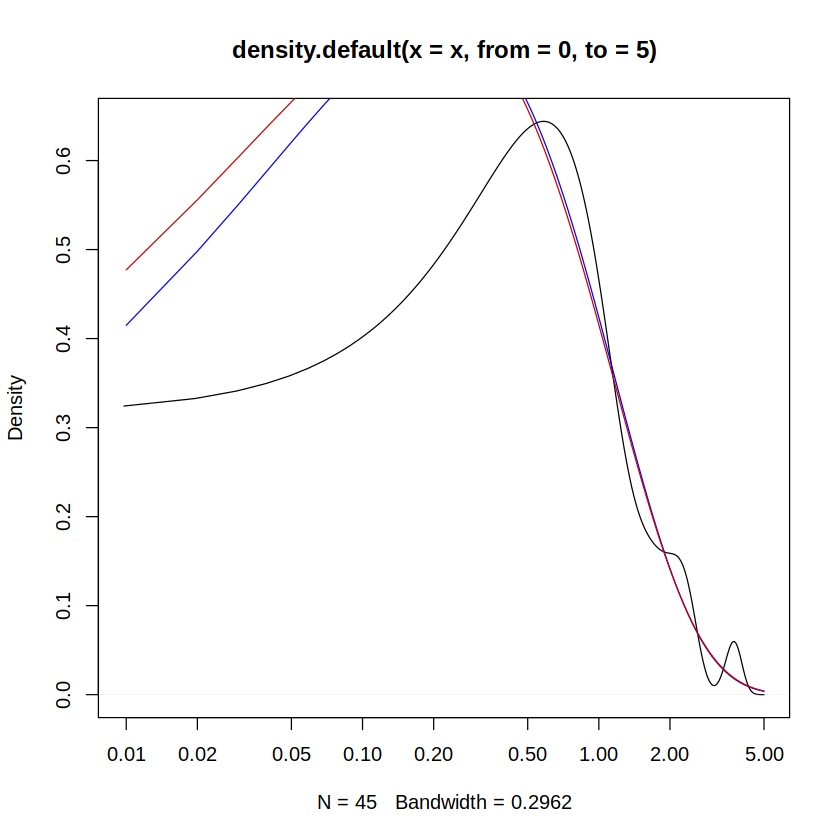

In [19]:
plot(density(x, from = 0, to = 5), log = "x")
lines(seq(0,5,0.01), dgamma(seq(0,5,0.01), a, b), col = "blue")
lines(seq(0,5,0.01), dgamma(seq(0,5,0.01), shape = fitted.gamma$est["shape"], rate = fitted.gamma$est["rate"]), col = "red3")